In [91]:
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn

from matplotlib import cm
import matplotlib.pyplot as plt


import sys
sys.path.append('../')
from methods.s3w import s3wd,ri_s3wd, ari_s3wd
from methods.ssw import sswd
from methods.w import sph_wasserstein
from itertools import cycle
from utils import plot_utils, s3w_utils, vmf_utils, utils
from utils.s3w_utils import *
from utils.vmf_utils import *
import matplotlib.lines as mlines

import ot
from tqdm.notebook import tqdm
import time 

In [2]:
phi = (1 + np.sqrt(5)) / 2

vertices = np.array([
    [-1,  phi,  0],
    [ 1,  phi,  0],
    [-1, -phi,  0],
    [ 1, -phi,  0],
    [ 0, -1,  phi],
    [ 0,  1,  phi],
    [ 0, -1, -phi],
    [ 0,  1, -phi],
    [ phi,  0, -1],
    [ phi,  0,  1],
    [-phi,  0, -1],
    [-phi,  0,  1]
])

mus = F.normalize(torch.tensor(vertices, dtype=torch.float), p=2, dim=-1)
X = []
kappa = 50
N = 100   
for mu in mus:
    vmf = vmf_utils.rand_vmf(mu, kappa=kappa, N=N)
    X += list(vmf)

X = torch.tensor(X, dtype=torch.float)
Xt = X.clone().detach()




/tmp/ipykernel_59315/4216464679.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  X = torch.tensor(X, dtype=torch.float)


In [3]:
phi = (1 + np.sqrt(5)) / 2

vertices = np.array([
    [-1,  phi,  0],
    [ 1,  phi,  0],
    [-1, -phi,  0],
    [ 1, -phi,  0],
    [ 0, -1,  phi],
    [ 0,  1,  phi],
    [ 0, -1, -phi],
    [ 0,  1, -phi],
    [ phi,  0, -1],
    [ phi,  0,  1],
    [-phi,  0, -1],
    [-phi,  0,  1]
])

mus = F.normalize(torch.tensor(vertices, dtype=torch.float), p=2, dim=-1)
X = []
kappa = 50
N = 200   
for mu in mus:
    vmf = vmf_utils.rand_vmf(mu, kappa=kappa, N=N)
    X += list(vmf)

X = torch.tensor(X, dtype=torch.float)
Xt = X.clone().detach()




In [4]:
device='cuda:3'
Xt = Xt.to(device)
torch.manual_seed(1)
# X0 = torch.randn((N*12, 3), device=device)
# X0 = F.normalize(X0, p=2, dim=-1)
np.random.seed(1)
X0 = torch.tensor(vmf_utils.rand_vmf([-1,0,0], kappa=1, N=N*12), dtype=torch.float)
X0.requires_grad_(True)
X0=X0.to(device)


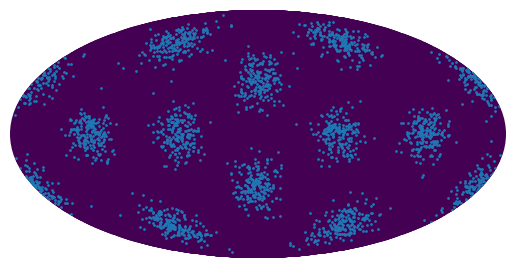

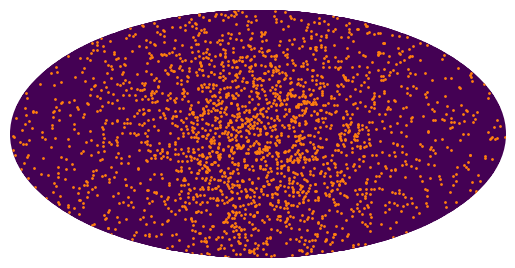

In [5]:
theta = np.linspace(0, 2 * np.pi, 2 * 100)
phi = np.linspace(0, np.pi, 100)
tp = np.array(np.meshgrid(theta, phi, indexing='ij')).transpose([1, 2, 0]).reshape(-1, 2)
heatmap = np.zeros((2 * 100, 100))
tt, pp = np.meshgrid(theta - np.pi, phi - np.pi / 2, indexing='ij')
spherical_coords = utils.euclidean_to_spherical(Xt.cpu())
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
ax.pcolormesh(tt, pp, heatmap)
ax.scatter(spherical_coords[:,0] - np.pi, spherical_coords[:,1] - np.pi/2, s=1,c='C0')
ax.set_axis_off()
plt.show()
spherical_coords = utils.euclidean_to_spherical(X0.detach().cpu())
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
ax.pcolormesh(tt, pp, heatmap)
ax.scatter(spherical_coords[:,0] - np.pi, spherical_coords[:,1] - np.pi/2, s=1,c='C1')
ax.set_axis_off()
plt.show()

In [6]:
def w2(X,Y,reg=1e-2):
    a = np.ones((X.shape[0],))/(X.shape[0],)
    b = np.ones((Y.shape[0],))/(Y.shape[0],)
    M = ot.dist(X,Y)
    dist = ot.sinkhorn2(a,b,M,reg=reg)
    return dist

def sw(X,Y,theta):
    X_slices = X@theta
    Y_slices = Y@theta
    return ((torch.sort(X_slices,dim=0)[0]-torch.sort(Y_slices,dim=0)[0])**2).sum(0).mean()
def t2n(X):
    return X.detach().cpu().numpy()

In [7]:
### Takes too long!
# tic = time.time()
# print(w2(t2n(X0),t2n(Xt),reg=1e-1))
# print(time.time()-tic)

In [8]:
torch.manual_seed(1)
theta = torch.randn(3,1024).to(device)
theta /= torch.norm(theta,p=2,dim=0,keepdim=True)
tic = time.time()
print(sw(X0,Xt,theta))
print(time.time()-tic)

tensor(104.6134, device='cuda:3', grad_fn=<MeanBackward0>)
1.9867372512817383


Training:   0%|          | 0/500 [00:00<?, ?it/s]

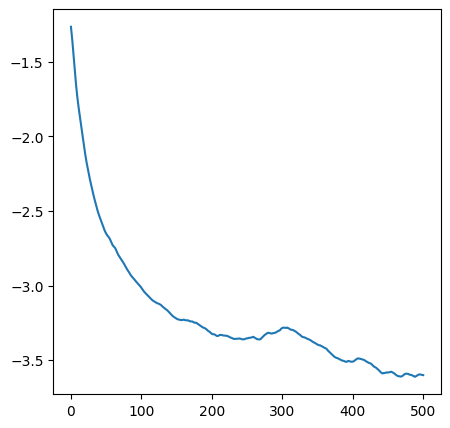

In [21]:
n_projs=1000
nepochs=500
lr = 0.03
torch.manual_seed(1)
X0 = torch.randn((N*12, 3), device=device)
X0 = F.normalize(X0, p=2, dim=-1)
X0.requires_grad_(True)
np.random.seed(1)
# X0 = torch.tensor(vmf_utils.rand_vmf([-1,0,0], kappa=1, N=N*12), dtype=torch.float).to(device)
# X0.requires_grad_(True)
optimizer = torch.optim.Adam([X0], lr=lr)
# optimizer = torch.optim.SGD([X0], lr=lr)
loss_iter = []
fig = plt.figure(figsize=(5,5))
comp_times0 = []
distances = []
distances.append(sph_wasserstein(X0.clone().detach().cpu(),Xt.clone().detach().cpu(),2).item())
pbar = tqdm(range(nepochs), desc="Training")
scheduler=LinearRS(1, 30, nepochs)
for i in pbar:
    optimizer.zero_grad()
    tic = time.time()
    
    loss = ari_s3wd(X0, Xt, n_projs=n_projs, p=2, n_rotations=scheduler.get(), pool_size=1000, device=device)
    loss.backward()    
    optimizer.step()
    scheduler.step()
    toc = time.time()
    X0.data /= torch.norm(X0.data, dim=1, keepdim=True)    
    comp_times0.append(toc - tic)
    
    sphd_distance = sph_wasserstein(X0.clone().detach().cpu(), Xt.clone().detach().cpu(), p=2).item()
    distances.append(sphd_distance)


    pbar.set_postfix(Loss=loss.item(), Sphd_Wasserstein=sphd_distance)

plt.plot(np.log10(distances))

Training:   0%|          | 0/500 [00:00<?, ?it/s]

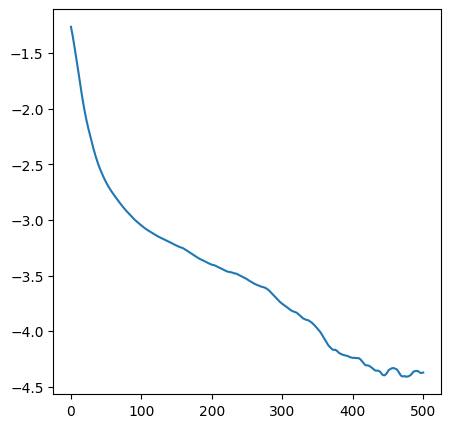

In [23]:
n_projs=1000
nepochs=500
lr = 0.01
torch.manual_seed(1)
X0 = torch.randn((N*12, 3), device=device)
X0 = F.normalize(X0, p=2, dim=-1)
X0.requires_grad_(True)
np.random.seed(1)
# X0 = torch.tensor(vmf_utils.rand_vmf([-1,0,0], kappa=1, N=N*12), dtype=torch.float).to(device)
# X0.requires_grad_(True)
optimizer = torch.optim.Adam([X0], lr=lr)
# optimizer = torch.optim.SGD([X0], lr=lr)
loss_iter = []
fig = plt.figure(figsize=(5,5))
comp_times = []
distances1 = []
distances1.append(sph_wasserstein(X0.clone().detach().cpu(),Xt.clone().detach().cpu(),2).item())
pbar = tqdm(range(nepochs), desc="Training")
for i in pbar:
    optimizer.zero_grad()
    tic = time.time()
    
    loss = ari_s3wd(X0, Xt, n_projs=n_projs, p=2, n_rotations=30, pool_size=1000, device=device)
    loss.backward()    
    optimizer.step()
    toc = time.time()
    X0.data /= torch.norm(X0.data, dim=1, keepdim=True)    
    comp_times.append(toc - tic)
    
    sphd_distance = sph_wasserstein(X0.clone().detach().cpu(), Xt.clone().detach().cpu(), p=2).item()
    distances1.append(sphd_distance)


    pbar.set_postfix(Loss=loss.item(), Sphd_Wasserstein=sphd_distance)

plt.plot(np.log10(distances1))

In [32]:
# n_projs=1000
# nepochs=500
# lr = 0.1
# torch.manual_seed(1)
# # X0 = torch.randn((N*12, 3), device=device)
# # X0 = F.normalize(X0, p=2, dim=-1)
# # X0.requires_grad_(True)
# np.random.seed(1)
# X0 = torch.tensor(vmf_utils.rand_vmf([-1,0,0], kappa=1, N=N*12), dtype=torch.float).to(device)
# X0.requires_grad_(True)
# optimizer = torch.optim.Adam([X0], lr=lr)
# # optimizer = torch.optim.SGD([X0], lr=lr)
# loss_iter = []
# fig = plt.figure(figsize=(5,5))
# comp_times = []
# distances1 = []
# distances1.append(sph_wasserstein(X0.clone().detach().cpu(),Xt.clone().detach().cpu(),2).item())
# pbar = tqdm(range(nepochs), desc="Training")

# for i in pbar:
#     optimizer.zero_grad()
#     tic = time.time()
    
#     loss = ari_s3wd(X0, Xt, n_projs=n_projs, p=2, n_rotations=50, pool_size=1000, device=device)
#     loss.backward()    
#     optimizer.step()
    
#     toc = time.time()
#     X0.data /= torch.norm(X0.data, dim=1, keepdim=True)    
#     comp_times.append(toc - tic)
    
#     sphd_distance = sph_wasserstein(X0.clone().detach().cpu(), Xt.clone().detach().cpu(), p=2).item()
#     distances1.append(sphd_distance)


#     pbar.set_postfix(Loss=loss.item(), Sphd_Wasserstein=sphd_distance)

# plt.plot(np.log10(distances))

Training RI-S3W:   0%|          | 0/500 [00:00<?, ?it/s]

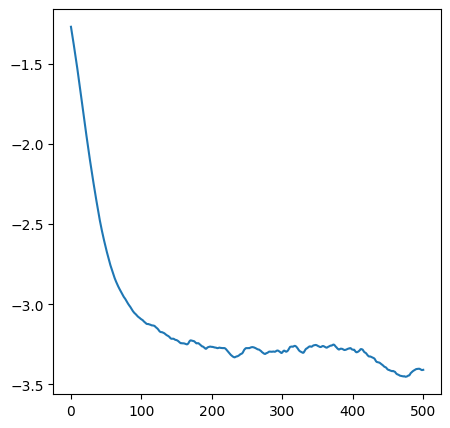

In [24]:
n_projs=1000
nepochs=500
lr = 0.01
torch.manual_seed(2)
X0 = torch.randn((N*12, 3), device=device)
X0 = F.normalize(X0, p=2, dim=-1)
X0.requires_grad_(True)
np.random.seed(1)
# X0 = torch.tensor(vmf_utils.rand_vmf([-1,0,0], kappa=1, N=N*12), dtype=torch.float).to(device)
# X0.requires_grad_(True)
optimizer = torch.optim.Adam([X0], lr=lr)
# optimizer = torch.optim.SGD([X0], lr=lr)
loss_iter = []
fig = plt.figure(figsize=(5,5))
comp_times_ri5 = []
distances_ri5 = []
distances_ri5.append(sph_wasserstein(X0.clone().detach().cpu(),Xt.clone().detach().cpu(),2).item())
pbar = tqdm(range(nepochs), desc="Training RI-S3W")
for i in pbar:
    optimizer.zero_grad()
    tic = time.time()
    loss = ri_s3wd(X0, Xt, n_projs=n_projs, p=2, n_rotations=5, device=device)
    loss.backward()    
    optimizer.step()
    toc = time.time()
    X0.data /= torch.norm(X0.data, dim=1, keepdim=True)    
    comp_times_ri5.append(toc - tic)
    sphd_distance = sph_wasserstein(X0.clone().detach().cpu(), Xt.clone().detach().cpu(), p=2).item()
    distances_ri5.append(sphd_distance)
    pbar.set_postfix(Loss=loss.item(), Sphd_Wasserstein=sphd_distance)
plt.plot(np.log10(distances_ri5))

  0%|          | 0/500 [00:00<?, ?it/s]

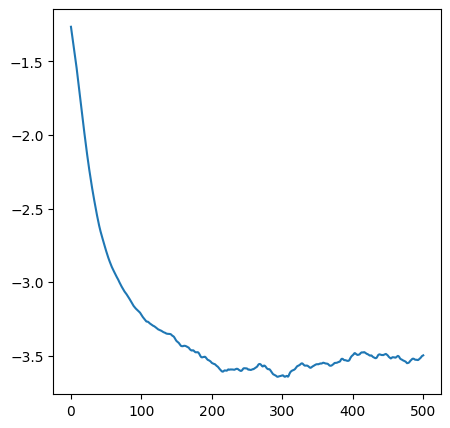

In [25]:
n_projs=1000
nepochs=500
lr = 0.01
torch.manual_seed(1)
X0 = torch.randn((N*12, 3), device=device)
X0 = F.normalize(X0, p=2, dim=-1)
X0.requires_grad_(True)
# np.random.seed(1)
# X0 = torch.tensor(vmf_utils.rand_vmf([-1,0,0], kappa=1, N=N*12), dtype=torch.float).to(device)
X0.requires_grad_(True)
optimizer = torch.optim.Adam([X0], lr=lr)
# optimizer = torch.optim.SGD([X0], lr=lr)
loss_iter = []
fig = plt.figure(figsize=(5,5))
comp_times_ri10 = []
distances_ri10 = []
distances_ri10.append(sph_wasserstein(X0.clone().detach().cpu(),Xt.clone().detach().cpu(),2).item())
for i in tqdm(range(nepochs)):
    optimizer.zero_grad()
    tic = time.time()
    loss = ri_s3wd(X0,Xt,n_projs=n_projs,p=2,n_rotations=10,device=device)
    loss.backward()    
    optimizer.step()
    toc = time.time()
    X0.data/=torch.norm(X0.data,dim=1,keepdim=True)    
    comp_times_ri10.append(toc-tic)
    distances_ri10.append(sph_wasserstein(X0.clone().detach().cpu(),Xt.clone().detach().cpu(),p=2).item())
plt.plot(np.log10(distances_ri10))

  0%|          | 0/500 [00:00<?, ?it/s]

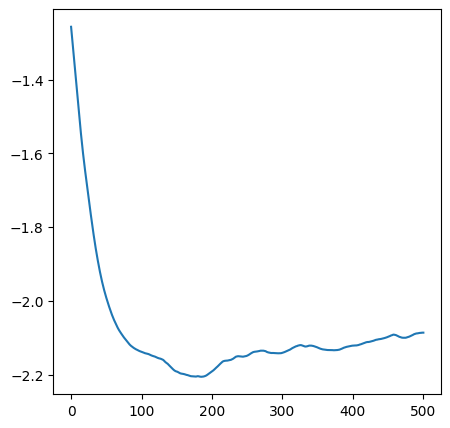

In [280]:
lr = 0.01
torch.manual_seed(3)
np.random.seed(3)
# X0 = torch.tensor(vmf_utils.rand_vmf([-1,0,0], kappa=1, N=N*12), dtype=torch.float).to(device)
# X0.requires_grad_(True)
X0 = torch.randn((N*12, 3), device=device)
X0 = F.normalize(X0, p=2, dim=-1)
X0.requires_grad_(True)
optimizer = torch.optim.Adam([X0], lr=lr)

loss_iter = []
fig = plt.figure(figsize=(5,5))
comp_times_s3w = []
distances_s3w = []
distances_s3w.append(sph_wasserstein(X0.clone().detach().cpu(),Xt.clone().detach().cpu(),2).item())
for i in tqdm(range(nepochs)):
    optimizer.zero_grad()
    tic = time.time()
    loss = s3wd(X0,Xt,n_projs=n_projs,p=2,random_pnp=False,device=device)
    loss.backward()    
    optimizer.step()
    toc = time.time()
    X0.data/=torch.norm(X0.data,dim=1,keepdim=True)    
    comp_times_s3w.append(toc-tic)
    distances_s3w.append(sph_wasserstein(X0.clone().detach().cpu(),Xt.clone().detach().cpu(),2).item())
plt.plot(np.log10(distances_s3w))

  0%|          | 0/500 [00:00<?, ?it/s]

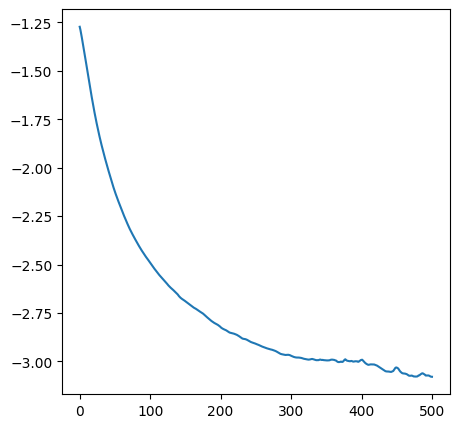

In [279]:
lr = 0.01
torch.manual_seed(4)
np.random.seed(4)
# X0 = torch.tensor(vmf_utils.rand_vmf([-1,0,0], kappa=1, N=N*12), dtype=torch.float).to(device)
# X0.requires_grad_(True)
X0 = torch.randn((N*12, 3), device=device)
X0 = F.normalize(X0, p=2, dim=-1)
X0.requires_grad_(True)
optimizer = torch.optim.Adam([X0], lr=lr)

loss_iter = []
fig = plt.figure(figsize=(5,5))
comp_times_ri1 = []
distances_ri1 = []
distances_ri1.append(sph_wasserstein(X0.clone().detach().cpu(),Xt.clone().detach().cpu(),2).item())
for i in tqdm(range(nepochs)):
    optimizer.zero_grad()
    tic = time.time()
    loss = s3wd(X0,Xt,n_projs=n_projs,p=2,random_pnp=True,device=device)
    loss.backward()    
    optimizer.step()
    toc = time.time()
    X0.data/=torch.norm(X0.data,dim=1,keepdim=True)    
    comp_times_ri1.append(toc-tic)
    distances_ri1.append(sph_wasserstein(X0.clone().detach().cpu(),Xt.clone().detach().cpu(),2).item())
plt.plot(np.log10(distances_ri1))

  0%|          | 0/500 [00:00<?, ?it/s]

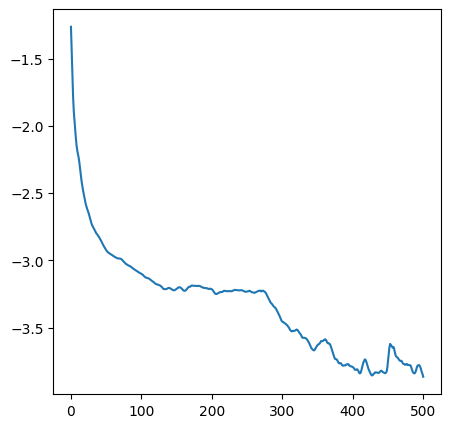

In [283]:
lr = 0.05 # 1e-1 is almost too large (alternating behavior)
torch.manual_seed(1)
X0 = torch.randn((N*12, 3), device=device)
X0 = F.normalize(X0, p=2, dim=-1)
X0.requires_grad_(True)
np.random.seed(1)
# X0 = torch.tensor(vmf_utils.rand_vmf([-1,0,0], kappa=1, N=N*12), dtype=torch.float).to(device)
# X0.requires_grad_(True)
optimizer = torch.optim.Adam([X0], lr=lr)
fig = plt.figure(figsize=(5,5))
comp_times_ssw = []
distances_ssw = []
distances_ssw.append(sph_wasserstein(X0.clone().detach().cpu(),Xt.clone().detach().cpu(),2).item())
for i in tqdm(range(nepochs)):
    optimizer.zero_grad()
    tic = time.time()
    loss = sswd(X0,Xt,p=2,num_projections=n_projs,device=device)    
    loss.backward()    
    optimizer.step()
    toc = time.time()
    X0.data/=torch.norm(X0.data,dim=1,keepdim=True)    
    comp_times_ssw.append(toc-tic)
    distances_ssw.append(sph_wasserstein(X0.clone().detach().cpu(),Xt.clone().detach().cpu(),2).item())
plt.plot(np.log10(distances_ssw))

  0%|          | 0/500 [00:00<?, ?it/s]

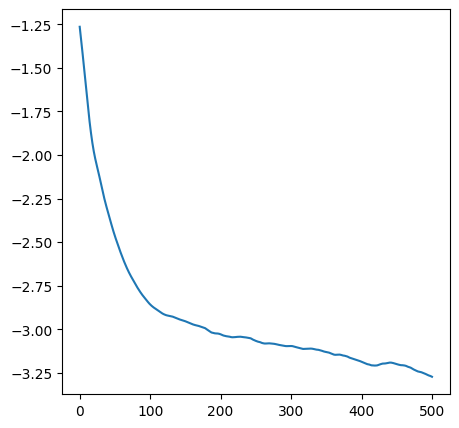

In [29]:
lr = 0.01 # 1e-1 is almost too large (alternating behavior)
torch.manual_seed(1)
X0 = torch.randn((N*12, 3), device=device)
X0 = F.normalize(X0, p=2, dim=-1)
X0.requires_grad_(True)
np.random.seed(1)
# X0 = torch.tensor(vmf_utils.rand_vmf([-1,0,0], kappa=1, N=N*12), dtype=torch.float).to(device)
# X0.requires_grad_(True)
optimizer = torch.optim.Adam([X0], lr=lr)
fig = plt.figure(figsize=(5,5))
comp_times_ssw1 = []
distances_ssw1 = []
distances_ssw1.append(sph_wasserstein(X0.clone().detach().cpu(),Xt.clone().detach().cpu(),2).item())
for i in tqdm(range(nepochs)):
    optimizer.zero_grad()
    tic = time.time()
    loss = sswd(X0,Xt,p=2,num_projections=n_projs,device=device)    
    loss.backward()    
    optimizer.step()
    toc = time.time()
    X0.data/=torch.norm(X0.data,dim=1,keepdim=True)    
    comp_times_ssw1.append(toc-tic)
    distances_ssw1.append(sph_wasserstein(X0.clone().detach().cpu(),Xt.clone().detach().cpu(),2).item())
plt.plot(np.log10(distances_ssw1))

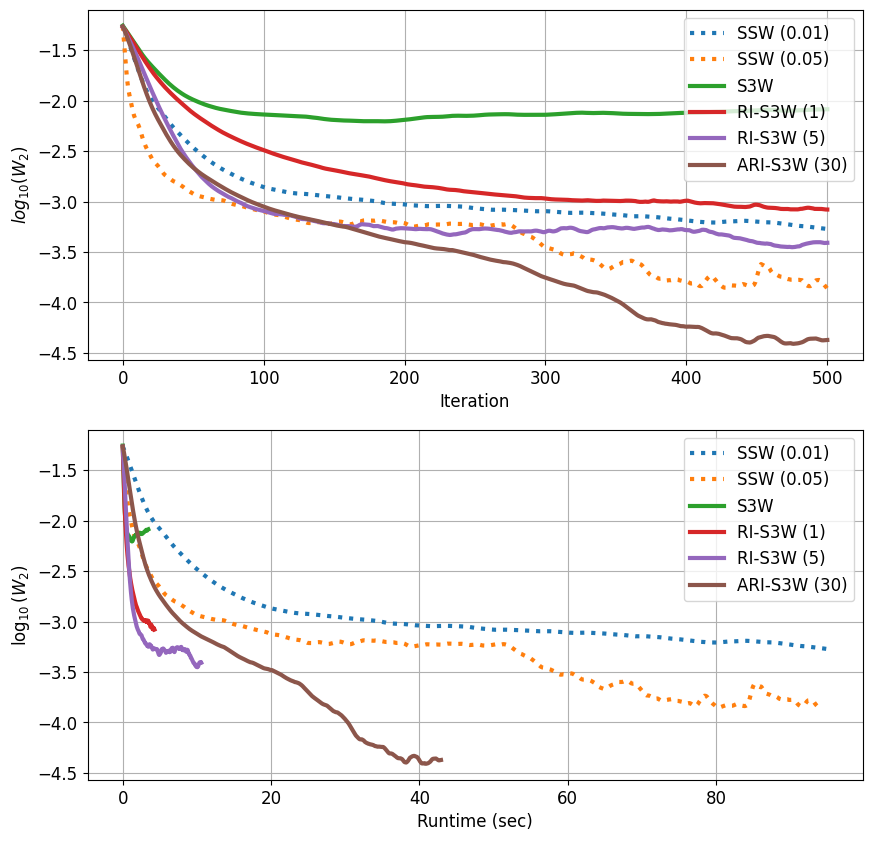

In [286]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
lw = 3
fs = 12

ax[0].plot(np.log10(distances_ssw1), label='SSW (0.01)', linewidth=lw, linestyle='dotted')
ax[0].plot(np.log10(distances_ssw), label='SSW (0.05)', linewidth=lw, linestyle='dotted')
ax[0].plot(np.log10(distances_s3w), label='S3W', linewidth=lw)
ax[0].plot(np.log10(distances_ri1), label='RI-S3W (1)', linewidth=lw)
ax[0].plot(np.log10(distances_ri5), label='RI-S3W (5)', linewidth=lw)
ax[0].plot(np.log10(distances1), label='ARI-S3W (30)', linewidth=lw)
# ax[0].plot(np.log10(distances), label='ARI-S3W (L1-30/1000)', linewidth=lw)
# ax[0].plot(np.log10(distances1), label='ARI-S3W (100/1000) 1', linewidth=lw)
ax[0].legend(fontsize=fs)
ax[0].grid('on')
ax[0].set_xlabel('Iteration', fontsize=fs)
ax[0].set_ylabel(r'$log_{10}(W_2)$', fontsize=fs)

ax[1].plot(np.cumsum([0] + comp_times_ssw1), np.log10(distances_ssw1), label='SSW (0.01)', linewidth=lw, linestyle='dotted')
ax[1].plot(np.cumsum([0] + comp_times_ssw), np.log10(distances_ssw), label='SSW (0.05)', linewidth=lw, linestyle='dotted')
ax[1].plot(np.cumsum([0] + comp_times_s3w), np.log10(distances_s3w), label='S3W', linewidth=lw)
ax[1].plot(np.cumsum([0] + comp_times_ri1), np.log10(distances_ri1), label='RI-S3W (1)', linewidth=lw)
ax[1].plot(np.cumsum([0] + comp_times_ri5), np.log10(distances_ri5), label='RI-S3W (5)', linewidth=lw)
ax[1].plot(np.cumsum([0] + comp_times), np.log10(distances1), label='ARI-S3W (30)', linewidth=lw)
# ax[1].plot(np.cumsum([0] + comp_times0), np.log10(distances), label='ARI-S3W (L1-30/1000)', linewidth=lw)

ax[1].legend(fontsize=fs)
ax[1].grid('on')
ax[1].set_ylabel(r'$\log_{10}(W_2)$', fontsize=fs)
ax[1].set_xlabel('Runtime (sec)', fontsize=fs)

for i in range(2):
    ax[i].tick_params(axis="both", labelsize=fs)

plt.show()

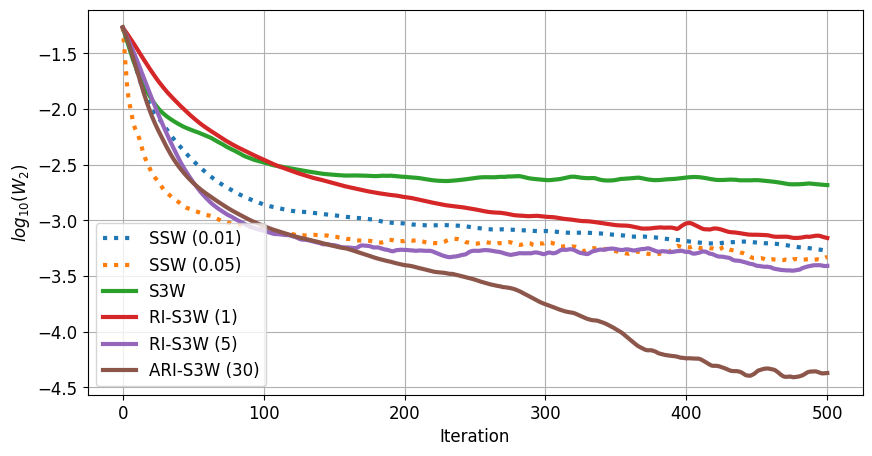

In [34]:
fig1, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(np.log10(distances_ssw1), label='SSW (0.01)', linewidth=lw, linestyle='dotted')
ax1.plot(np.log10(distances_ssw), label='SSW (0.05)', linewidth=lw, linestyle='dotted')  # Adding SSW1
ax1.plot(np.log10(distances_s3w), label='S3W', linewidth=lw)
ax1.plot(np.log10(distances_ri1), label='RI-S3W (1)', linewidth=lw)
ax1.plot(np.log10(distances_ri5), label='RI-S3W (5)', linewidth=lw)
# ax1.plot(np.log10(distances1), label='ARI-S3W (50)', linewidth=lw)  # Uncomment if needed
ax1.plot(np.log10(distances1), label='ARI-S3W (30)', linewidth=lw)
ax1.legend(fontsize=fs)
ax1.grid('on')
ax1.set_xlabel('Iteration', fontsize=fs)
ax1.set_ylabel(r'$log_{10}(W_2)$', fontsize=fs)
ax1.tick_params(axis="both", labelsize=fs)

plt.savefig('EVO_all_iteration_unif.pdf', bbox_inches='tight')  # Save the first plot to a PDF
plt.show()

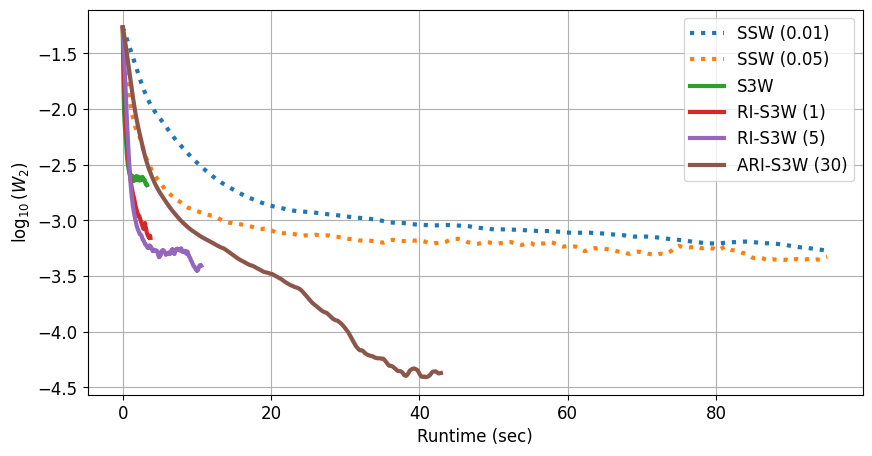

In [35]:
fig2, ax2 = plt.subplots(figsize=(10, 5))

ax2.plot(np.cumsum([0] + comp_times_ssw1), np.log10(distances_ssw1), label='SSW (0.01)', linewidth=lw, linestyle='dotted')  # Adding SSW1
ax2.plot(np.cumsum([0] + comp_times_ssw), np.log10(distances_ssw), label='SSW (0.05)', linewidth=lw, linestyle='dotted')
ax2.plot(np.cumsum([0] + comp_times_s3w), np.log10(distances_s3w), label='S3W', linewidth=lw)
ax2.plot(np.cumsum([0] + comp_times_ri1), np.log10(distances_ri1), label='RI-S3W (1)', linewidth=lw)
ax2.plot(np.cumsum([0] + comp_times_ri5), np.log10(distances_ri5), label='RI-S3W (5)', linewidth=lw)
# ax2.plot(np.cumsum([0] + comp_times), np.log10(distances1), label='ARI-S3W (50)', linewidth=lw)  # Uncomment if needed
ax2.plot(np.cumsum([0] + comp_times), np.log10(distances1), label='ARI-S3W (30)', linewidth=lw)
ax2.legend(fontsize=fs)
ax2.grid('on')
ax2.set_ylabel(r'$\log_{10}(W_2)$', fontsize=fs)
ax2.set_xlabel('Runtime (sec)', fontsize=fs)
ax2.tick_params(axis="both", labelsize=fs)

plt.savefig('EVO_all_runtime_unif.pdf', bbox_inches='tight')  # Save the second plot to a PDF
plt.show()

In [284]:
print(np.log10(distances_ssw1[-1]))
print(np.log10(distances_ssw[-1]))
print(np.log10(distances_s3w[-1]))
print(np.log10(distances_ri1[-1]))
print(np.log10(distances_ri5[-1]))
print(np.log10(distances1[-1]))

-3.2720188577892335
-3.8636196512091328
-2.0857263802864545
-3.078972792292773
-3.4087260780637036
-4.371541893733858


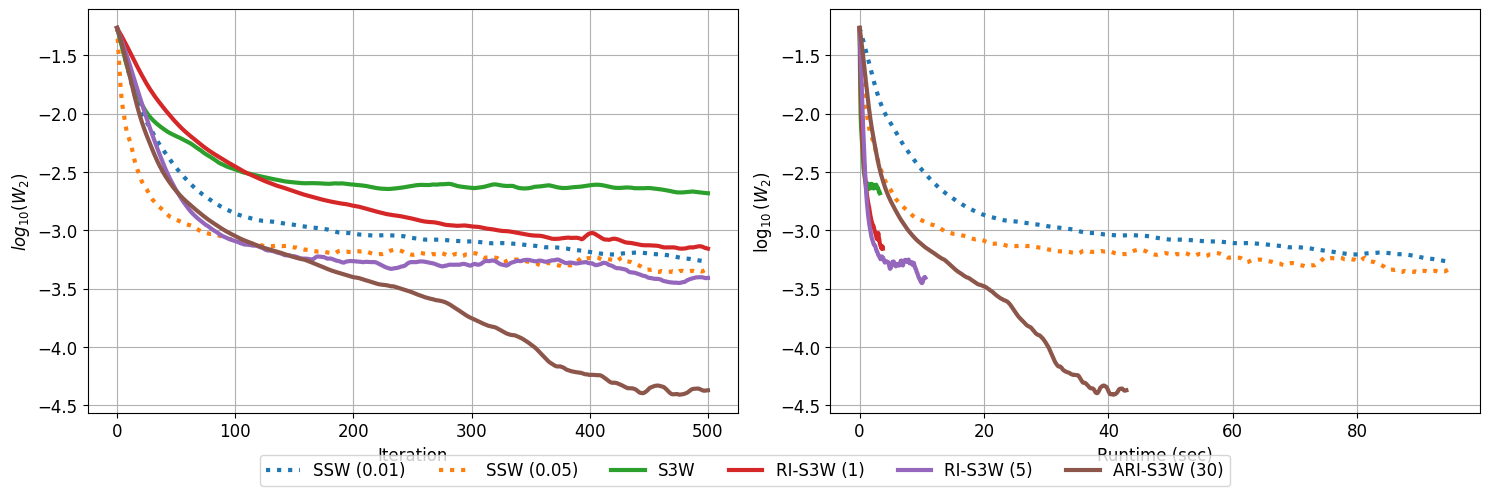

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
lw = 3
fs = 12

ax[0].plot(np.log10(distances_ssw1), label='SSW (0.01)', linewidth=lw, linestyle='dotted')
ax[0].plot(np.log10(distances_ssw), label='SSW (0.05)', linewidth=lw, linestyle='dotted')
ax[0].plot(np.log10(distances_s3w), label='S3W', linewidth=lw)
ax[0].plot(np.log10(distances_ri1), label='RI-S3W (1)', linewidth=lw)
ax[0].plot(np.log10(distances_ri5), label='RI-S3W (5)', linewidth=lw)
ax[0].plot(np.log10(distances1), label='ARI-S3W (30)', linewidth=lw)
ax[0].grid('on')
ax[0].set_xlabel('Iteration', fontsize=fs)
ax[0].set_ylabel(r'$log_{10}(W_2)$', fontsize=fs)
ax[0].tick_params(axis="both", labelsize=fs)

ax[1].plot(np.cumsum([0] + comp_times_ssw1), np.log10(distances_ssw1), label='SSW (0.01)', linewidth=lw, linestyle='dotted')
ax[1].plot(np.cumsum([0] + comp_times_ssw), np.log10(distances_ssw), label='SSW (0.05)', linewidth=lw, linestyle='dotted')
ax[1].plot(np.cumsum([0] + comp_times_s3w), np.log10(distances_s3w), label='S3W', linewidth=lw)
ax[1].plot(np.cumsum([0] + comp_times_ri1), np.log10(distances_ri1), label='RI-S3W (1)', linewidth=lw)
ax[1].plot(np.cumsum([0] + comp_times_ri5), np.log10(distances_ri5), label='RI-S3W (5)', linewidth=lw)
ax[1].plot(np.cumsum([0] + comp_times), np.log10(distances1), label='ARI-S3W (30)', linewidth=lw)
ax[1].grid('on')
ax[1].set_xlabel('Runtime (sec)', fontsize=fs)
ax[1].set_ylabel(r'$\log_{10}(W_2)$', fontsize=fs)
ax[1].tick_params(axis="both", labelsize=fs)

# Remove individual legends
ax[0].legend().set_visible(False)
ax[1].legend().set_visible(False)

# Add a shared legend at the bottom
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize=fs, bbox_to_anchor=(0.5, 0))

# Adjusting the layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 1])

plt.show()

In [282]:
print(np.sum(comp_times_ssw1))
print(np.sum(comp_times_ssw))
print(np.sum(comp_times_s3w))
print(np.sum(comp_times_ri1))
print(np.sum(comp_times_ri5))
print(np.sum(comp_times))

94.97186827659607
95.00321745872498
3.4411139488220215
4.274816989898682
10.579502582550049
42.89972281455994


In [ ]:
ax[1].plot(np.cumsum([0] + comp_times_ssw1), np.log10(distances_ssw1), label='SSW (0.01)', linewidth=lw, linestyle='dotted')
ax[1].plot(np.cumsum([0] + comp_times_ssw), np.log10(distances_ssw), label='SSW (0.05)', linewidth=lw, linestyle='dotted')
ax[1].plot(np.cumsum([0] + comp_times_s3w), np.log10(distances_s3w), label='S3W', linewidth=lw)
ax[1].plot(np.cumsum([0] + comp_times_ri1), np.log10(distances_ri1), label='RI-S3W (1)', linewidth=lw)
ax[1].plot(np.cumsum([0] + comp_times_ri5), np.log10(distances_ri5), label='RI-S3W (5)', linewidth=lw)
ax[1].plot(np.cumsum([0] + comp_times), np.log10(distances1), label='ARI-S3W (30)', linewidth=lw)

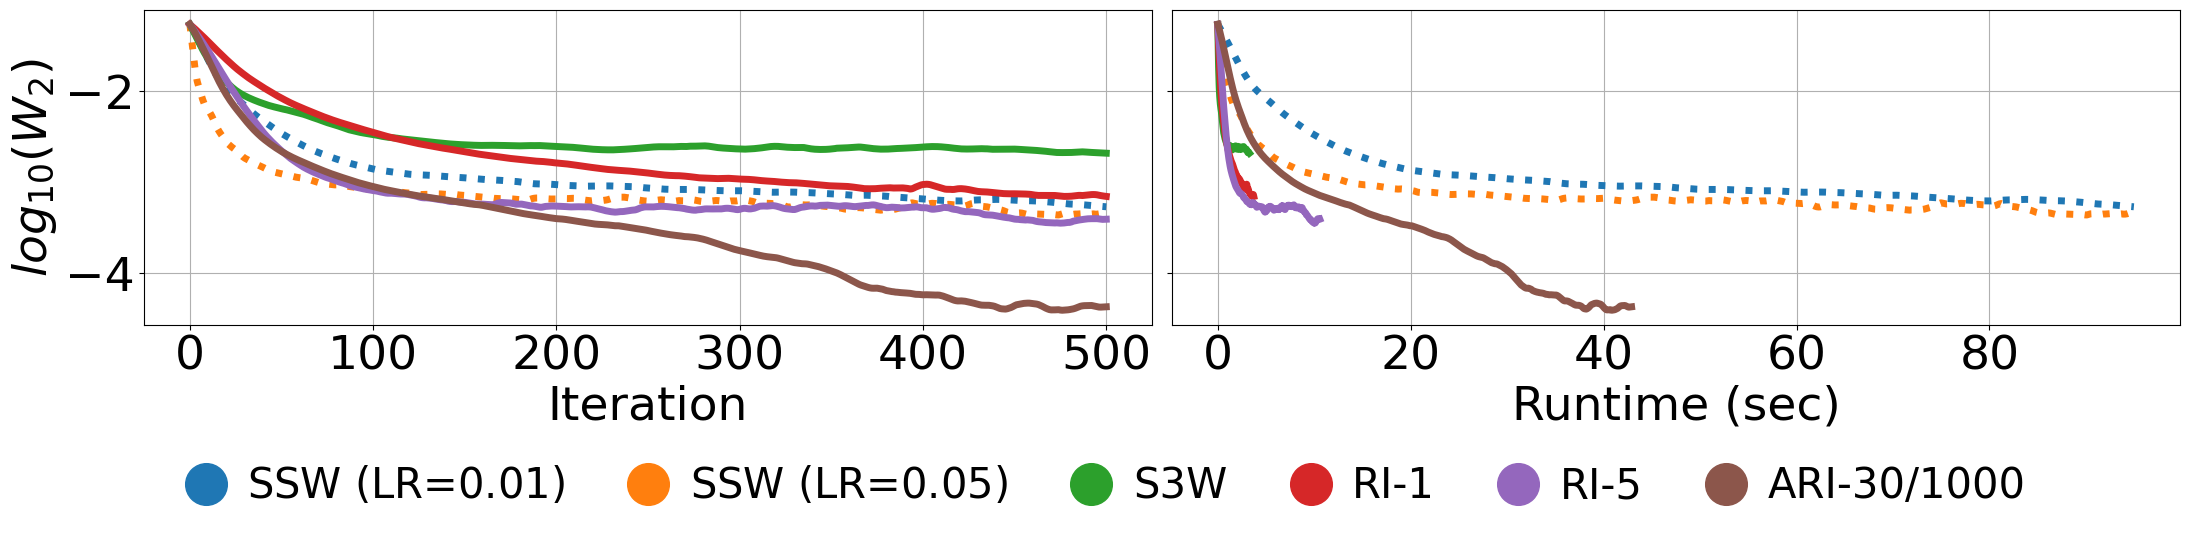

In [114]:
fig, ax = plt.subplots(1, 2, figsize=(22, 5), sharey=True)
lw = 5
fs = 34
legend_fs = 30  # Font size for the legend

ax[0].plot(np.log10(distances_ssw1), label='SSW (0.01)', linewidth=lw, linestyle='dotted')
ax[0].plot(np.log10(distances_ssw), label='SSW (0.05)', linewidth=lw, linestyle='dotted')
ax[0].plot(np.log10(distances_s3w), label='S3W', linewidth=lw)
ax[0].plot(np.log10(distances_ri1), label='RI-S3W (1)', linewidth=lw)
ax[0].plot(np.log10(distances_ri5), label='RI-S3W (5)', linewidth=lw)
ax[0].plot(np.log10(distances1), label='ARI-S3W (30)', linewidth=lw)
ax[0].grid('on')
ax[0].set_xlabel('Iteration', fontsize=fs)
ax[0].set_ylabel(r'$log_{10}(W_2)$', fontsize=fs)
ax[0].tick_params(axis="both", labelsize=fs)

ax[1].plot(np.cumsum([0] + comp_times_ssw1), np.log10(distances_ssw1), label='SSW (0.01)', linewidth=lw, linestyle='dotted')
ax[1].plot(np.cumsum([0] + comp_times_ssw), np.log10(distances_ssw), label='SSW (0.05)', linewidth=lw, linestyle='dotted')
ax[1].plot(np.cumsum([0] + comp_times_s3w), np.log10(distances_s3w), label='S3W', linewidth=lw)
ax[1].plot(np.cumsum([0] + comp_times_ri1), np.log10(distances_ri1), label='RI-S3W (1)', linewidth=lw)
ax[1].plot(np.cumsum([0] + comp_times_ri5), np.log10(distances_ri5), label='RI-S3W (5)', linewidth=lw)
ax[1].plot(np.cumsum([0] + comp_times), np.log10(distances1), label='ARI-S3W (30)', linewidth=lw)
ax[1].grid('on')
ax[1].set_xlabel('Runtime (sec)', fontsize=fs)
ax[1].tick_params(axis="both", labelsize=fs)

# Remove individual legends
ax[0].legend().set_visible(False)
ax[1].legend().set_visible(False)

# Adjust the spacing between the plots
plt.subplots_adjust(wspace=0.1)

legend_handles = [
    mlines.Line2D([], [], color='C0', marker='o', linestyle='None', markersize=30, label=r'SSW (LR=$0.01$)'),
    mlines.Line2D([], [], color='C1', marker='o', linestyle='None', markersize=30, label=r'SSW (LR=$0.05$)'),
    mlines.Line2D([], [], color='C2', marker='o', linestyle='None', markersize=30, label='S3W'),
    mlines.Line2D([], [], color='C3', marker='o', linestyle='None', markersize=30, label='RI-1'),
    mlines.Line2D([], [], color='C4', marker='o', linestyle='None', markersize=30, label='RI-5'),
    mlines.Line2D([], [], color='C5', marker='o', linestyle='None', markersize=30, label='ARI-30/1000')
]

leg = fig.legend(handles=legend_handles, loc='lower center', ncol=len(legend_handles), fontsize=legend_fs, 
                 bbox_to_anchor=(0.5, -0.1), frameon=False, columnspacing=1, handletextpad=0.0) 


# Adjust the layout and save the figure
plt.tight_layout(rect=[0, 0.1, 1, 1])
fig.savefig('./evo_main.pdf', bbox_inches='tight', dpi=500)
plt.show()

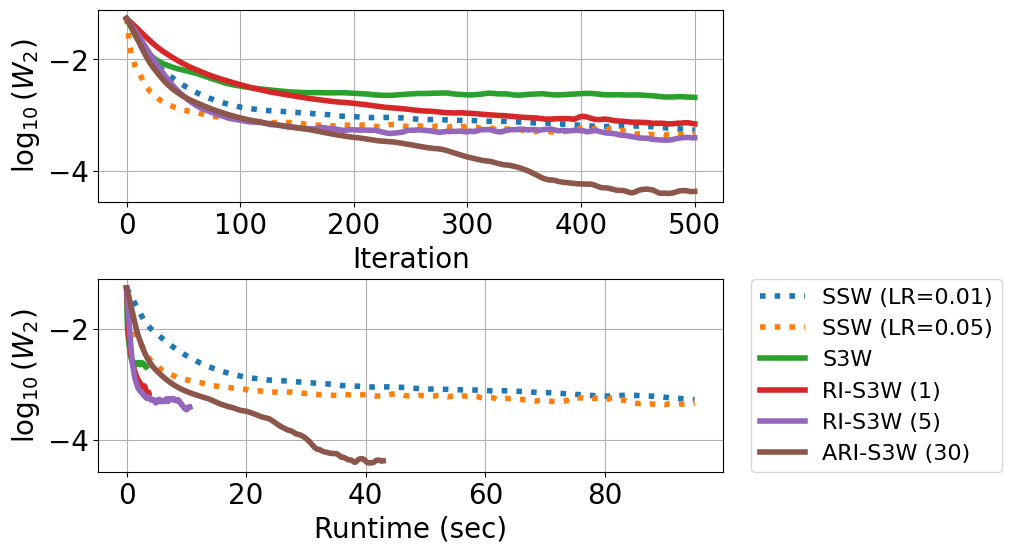

In [182]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
lw = 4
fs = 20

# Plotting for the first subplot
ax[0].plot(np.log10(distances_ssw1), label='SSW (LR=0.01)', linewidth=lw, linestyle='dotted')
ax[0].plot(np.log10(distances_ssw), label='SSW (LR=0.05)', linewidth=lw, linestyle='dotted')
ax[0].plot(np.log10(distances_s3w), label='S3W', linewidth=lw)
ax[0].plot(np.log10(distances_ri1), label='RI-S3W (1)', linewidth=lw)
ax[0].plot(np.log10(distances_ri5), label='RI-S3W (5)', linewidth=lw)
ax[0].plot(np.log10(distances1), label='ARI-S3W (30)', linewidth=lw)
ax[0].grid('on')
ax[0].set_xlabel('Iteration', fontsize=fs)
ax[0].set_ylabel(r'$\log_{10}(W_2)$', fontsize=fs)

# Plotting for the second subplot
ax[1].plot(np.cumsum([0] + comp_times_ssw1), np.log10(distances_ssw1), label='SSW (0.01)', linewidth=lw, linestyle='dotted')
ax[1].plot(np.cumsum([0] + comp_times_ssw), np.log10(distances_ssw), label='SSW (0.05)', linewidth=lw, linestyle='dotted')
ax[1].plot(np.cumsum([0] + comp_times_s3w), np.log10(distances_s3w), label='S3W', linewidth=lw)
ax[1].plot(np.cumsum([0] + comp_times_ri1), np.log10(distances_ri1), label='RI-S3W (1)', linewidth=lw)
ax[1].plot(np.cumsum([0] + comp_times_ri5), np.log10(distances_ri5), label='RI-S3W (5)', linewidth=lw)
ax[1].plot(np.cumsum([0] + comp_times), np.log10(distances1), label='ARI-S3W (30)', linewidth=lw)
ax[1].grid('on')
ax[1].set_xlabel('Runtime (sec)', fontsize=fs)
ax[1].set_ylabel(r'$\log_{10}(W_2)$', fontsize=fs)

# Setting tick parameters
for i in range(2):
    ax[i].tick_params(axis="both", labelsize=fs)

# Create a single legend outside the plots using the labels from one of the subplots
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', fontsize=16, bbox_to_anchor=(1.04, 0.27))

# Adjust subplot parameters to make room for the legend and to create space between subplots
plt.subplots_adjust(right=0.75, hspace=0.4)
fig.savefig('./evo_main.pdf', bbox_inches='tight', dpi=500)
plt.show()

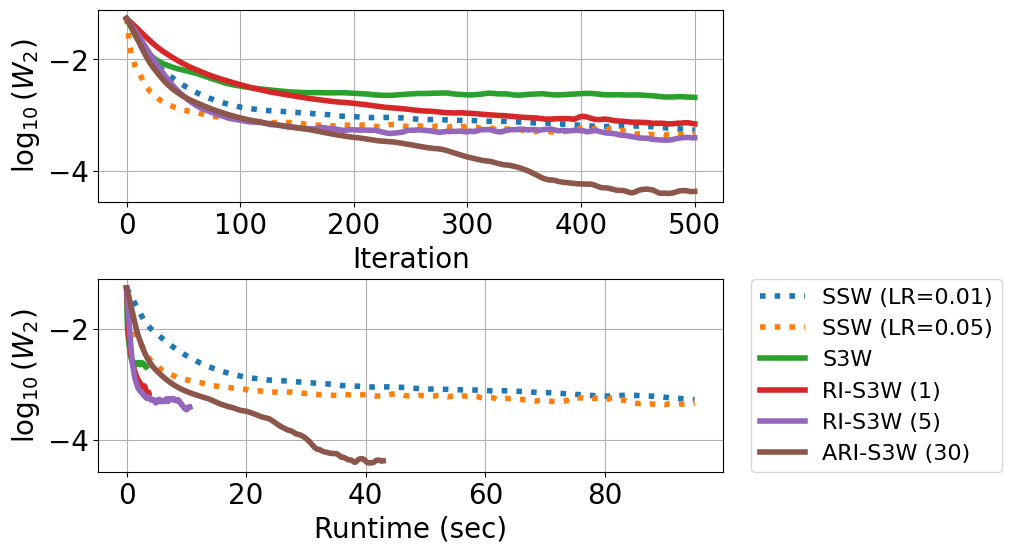

In [193]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], width_ratios=[1])

# Create the first subplot with the wider width using gridspec
ax0 = fig.add_subplot(gs[0])

# Plotting for the first subplot
lw = 4
fs = 20
ax0.plot(np.log10(distances_ssw1), label='SSW (LR=0.01)', linewidth=lw, linestyle='dotted')
ax0.plot(np.log10(distances_ssw), label='SSW (LR=0.05)', linewidth=lw, linestyle='dotted')
ax0.plot(np.log10(distances_s3w), label='S3W', linewidth=lw)
ax0.plot(np.log10(distances_ri1), label='RI-S3W (1)', linewidth=lw)
ax0.plot(np.log10(distances_ri5), label='RI-S3W (5)', linewidth=lw)
ax0.plot(np.log10(distances1), label='ARI-S3W (30)', linewidth=lw)
ax0.grid('on')
ax0.set_xlabel('Iteration', fontsize=fs)
ax0.set_ylabel(r'$\log_{10}(W_2)$', fontsize=fs)
ax0.tick_params(axis="both", labelsize=fs)

# Create the second subplot with the default width using gridspec
ax1 = fig.add_subplot(gs[1])

# Plotting for the second subplot
ax1.plot(np.cumsum([0] + comp_times_ssw1), np.log10(distances_ssw1), label='SSW (0.01)', linewidth=lw, linestyle='dotted')
ax1.plot(np.cumsum([0] + comp_times_ssw), np.log10(distances_ssw), label='SSW (0.05)', linewidth=lw, linestyle='dotted')
ax1.plot(np.cumsum([0] + comp_times_s3w), np.log10(distances_s3w), label='S3W', linewidth=lw)
ax1.plot(np.cumsum([0] + comp_times_ri1), np.log10(distances_ri1), label='RI-S3W (1)', linewidth=lw)
ax1.plot(np.cumsum([0] + comp_times_ri5), np.log10(distances_ri5), label='RI-S3W (5)', linewidth=lw)
ax1.plot(np.cumsum([0] + comp_times), np.log10(distances1), label='ARI-S3W (30)', linewidth=lw)
ax1.grid('on')
ax1.set_xlabel('Runtime (sec)', fontsize=fs)
ax1.set_ylabel(r'$\log_{10}(W_2)$', fontsize=fs)
ax1.tick_params(axis="both", labelsize=fs)

# Create a single legend outside the plots using the labels from one of the subplots
handles, labels = ax0.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', fontsize=16, bbox_to_anchor=(1.04, 0.27))

# Adjust subplot parameters to make room for the legend and to create space between subplots
plt.subplots_adjust(right=0.75, hspace=0.4)

# Save the figure
plt.savefig('./evo_main.pdf', bbox_inches='tight', dpi=500)

plt.show()

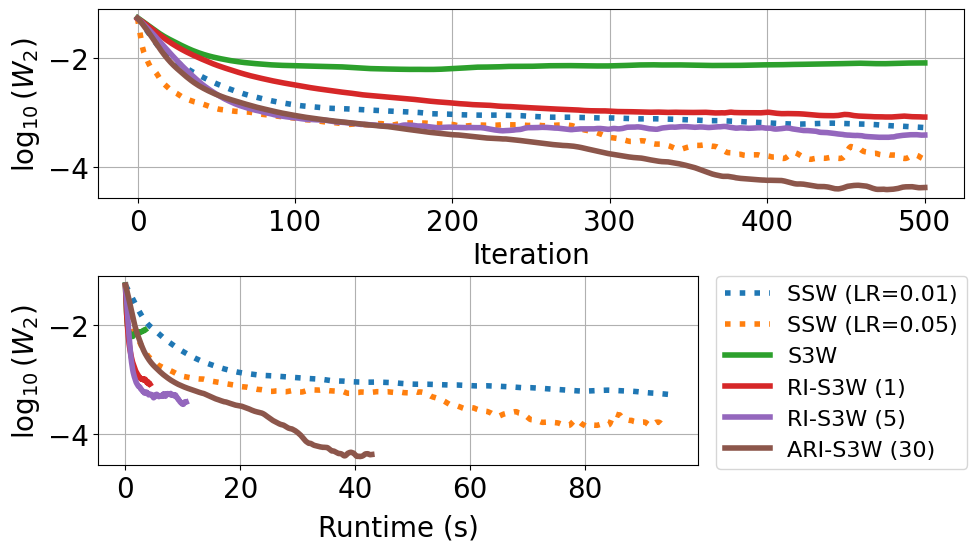

In [285]:
# Initialize the figure
fig = plt.figure(figsize=(10, 6))

# Define the space between the subplots
space_between_subplots = 0.05  # Adjust the space as needed

# Manually define the axes for the first subplot which will be wider
# We subtract the space_between_subplots to make room between the subplots
ax0_height = 0.34 - space_between_subplots / 2
ax0 = fig.add_axes([0.1, 0.55, 0.866, ax0_height])  # Adjust height as needed

# Plotting for the first (top) subplot
lw = 4
fs = 20
ax0.plot(np.log10(distances_ssw1), label='SSW (LR=0.01)', linewidth=lw, linestyle='dotted')
ax0.plot(np.log10(distances_ssw), label='SSW (LR=0.05)', linewidth=lw, linestyle='dotted')
ax0.plot(np.log10(distances_s3w), label='S3W', linewidth=lw)
ax0.plot(np.log10(distances_ri1), label='RI-S3W (1)', linewidth=lw)
ax0.plot(np.log10(distances_ri5), label='RI-S3W (5)', linewidth=lw)
ax0.plot(np.log10(distances1), label='ARI-S3W (30)', linewidth=lw)
ax0.grid('on')
ax0.set_xlabel('Iteration', fontsize=fs)
ax0.set_ylabel(r'$\log_{10}(W_2)$', fontsize=fs)
ax0.tick_params(axis="both", labelsize=fs)

# Manually define the axes for the second subplot which will be narrower
# The bottom position starts at 0.1 plus half the space between subplots
ax1_bottom = 0.08 + space_between_subplots / 2
ax1 = fig.add_axes([0.1, ax1_bottom, 0.6, ax0_height])  # Adjust height as needed

# Plotting for the second (bottom) subplot
ax1.plot(np.cumsum([0] + comp_times_ssw1), np.log10(distances_ssw1), label='SSW (0.01)', linewidth=lw, linestyle='dotted')
ax1.plot(np.cumsum([0] + comp_times_ssw), np.log10(distances_ssw), label='SSW (0.05)', linewidth=lw, linestyle='dotted')
ax1.plot(np.cumsum([0] + comp_times_s3w), np.log10(distances_s3w), label='S3W', linewidth=lw)
ax1.plot(np.cumsum([0] + comp_times_ri1), np.log10(distances_ri1), label='RI-S3W (1)', linewidth=lw)
ax1.plot(np.cumsum([0] + comp_times_ri5), np.log10(distances_ri5), label='RI-S3W (5)', linewidth=lw)
ax1.plot(np.cumsum([0] + comp_times), np.log10(distances1), label='ARI-S3W (30)', linewidth=lw)
ax1.grid('on')
ax1.set_xlabel('Runtime (s)', fontsize=fs, labelpad=8)

ax1.set_ylabel(r'$\log_{10}(W_2)$', fontsize=fs)
ax1.tick_params(axis="both", labelsize=fs)

# Create a single legend outside the plots using the labels from one of the subplots
handles, labels = ax0.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', fontsize=16, bbox_to_anchor=(0.98, 0.26))  # Adjust legend position as needed

# Save the figure
plt.savefig('./evo_main.pdf', bbox_inches='tight', dpi=500)

plt.show()

In [1]:
fig, ax = plt.subplots(2, 1, figsize=(22, 10), sharey=True)  # Changed to 2 rows, 1 column
lw = 5
fs = 34
legend_fs = 30  # Font size for the legend

# First subplot
ax[0].plot(np.log10(distances_ssw1), label='SSW (0.01)', linewidth=lw, linestyle='dotted')
ax[0].plot(np.log10(distances_ssw), label='SSW (0.05)', linewidth=lw, linestyle='dotted')
ax[0].plot(np.log10(distances_s3w), label='S3W', linewidth=lw)
ax[0].plot(np.log10(distances_ri1), label='RI-S3W (1)', linewidth=lw)
ax[0].plot(np.log10(distances_ri5), label='RI-S3W (5)', linewidth=lw)
ax[0].plot(np.log10(distances1), label='ARI-S3W (30)', linewidth=lw)
ax[0].grid('on')
ax[0].set_xlabel('Iteration', fontsize=fs)
ax[0].set_ylabel(r'$\log_{10}(W_2)$', fontsize=fs)
ax[0].tick_params(axis="both", labelsize=fs)

# Second subplot
ax[1].plot(np.cumsum([0] + comp_times_ssw1), np.log10(distances_ssw1), label='SSW (0.01)', linewidth=lw, linestyle='dotted')
ax[1].plot(np.cumsum([0] + comp_times_ssw), np.log10(distances_ssw), label='SSW (0.05)', linewidth=lw, linestyle='dotted')
ax[1].plot(np.cumsum([0] + comp_times_s3w), np.log10(distances_s3w), label='S3W', linewidth=lw)
ax[1].plot(np.cumsum([0] + comp_times_ri1), np.log10(distances_ri1), label='RI-S3W (1)', linewidth=lw)
ax[1].plot(np.cumsum([0] + comp_times_ri5), np.log10(distances_ri5), label='RI-S3W (5)', linewidth=lw)
ax[1].plot(np.cumsum([0] + comp_times), np.log10(distances1), label='ARI-S3W (30)', linewidth=lw)
ax[1].grid('on')
ax[1].set_xlabel('Runtime (sec)', fontsize=fs)
ax[1].tick_params(axis="both", labelsize=fs)

# Define custom legend handles
legend_handles = [
    mlines.Line2D([], [], color='C0', marker='o', linestyle='None', markersize=15, label=r'SSW (LR=$0.01$)'),
    mlines.Line2D([], [], color='C1', marker='o', linestyle='None', markersize=15, label=r'SSW (LR=$0.05$)'),
    mlines.Line2D([], [], color='C2', marker='o', linestyle='None', markersize=15, label='S3W'),
    mlines.Line2D([], [], color='C3', marker='o', linestyle='None', markersize=15, label='RI-1'),
    mlines.Line2D([], [], color='C4', marker='o', linestyle='None', markersize=15, label='RI-5'),
    mlines.Line2D([], [], color='C5', marker='o', linestyle='None', markersize=15, label='ARI-30/1000')
]

# Create the legend
leg = fig.legend(handles=legend_handles, loc='lower center', ncol=3, fontsize=legend_fs, 
                 bbox_to_anchor=(0.5, -0.05), frameon=False, columnspacing=1, handletextpad=0.0) 

# Adjust the layout to accommodate the legend
plt.tight_layout(rect=[0, 0.1, 1, 1])
fig.savefig('./evo_main.pdf', bbox_inches='tight', dpi=500)
plt.show()

NameError: name 'plt' is not defined